# 1. Overview

# 2. Comparison

## 2.1 Import Libraries

In [1]:
import pandas as pd
import json
import joblib
#import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series


## 2.2 Define Global Variables

In [2]:
output_best_variables_path_asml = 'data/best_prophet_variables_asml.json'
output_best_variables_path_asml_suppliers = 'data/best_prophet_variables_with_suppliers.json'
output_model_path_asml = 'models/prophet_simple_asml_model.pkl'
output_model_path_asml_suppliers = 'models/prophet_asml_combination_with_suppliers.pkl'
input_data = 'data/weekly_data_combination.csv'
test_weeks = 16

## 2.3 Code

### 2.3.1 Loading the best variables from notebooks 02 and 05

Load the best variables

In [3]:
with open(output_best_variables_path_asml, 'r') as file:
    best_prophet_variables_asml = json.load(file)
    
with open(output_best_variables_path_asml_suppliers, 'r') as file:
    best_prophet_variables_asml_suppliers = json.load(file)

### 2.3.2 Loading the best prophet models from notebooks 02 and 05

Load the best prophet models

In [4]:
# Load the model from the output_model_path_asml pickle file
prophet_model_best_asml = joblib.load(output_model_path_asml)

# Load the model from the output_model_path_asml_suppliers pickle file
prophet_model_best_asml_suppliers = joblib.load(output_model_path_asml_suppliers)

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### 2.3.3 Loading the data from notebook 04_data_preparation

In [5]:
weekly_data_combination = pd.read_csv(input_data, sep=';')

# Ensure the 'Date' column is in datetime format
weekly_data_combination['Date'] = pd.to_datetime(weekly_data_combination['Date'])

# Set the 'Date' column as the index to make it a DatetimeIndex
weekly_data_combination.set_index('Date', inplace=True)

# Explicitly set the frequency of the Date index
weekly_data_combination = weekly_data_combination.asfreq('W')


weekly_data_combination

,Close_ASML,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
Date,,,,,,,,,,,
2013-01-13,56.546021,26.057863,1.605489,7.480000,0,0,0,0,0,0,0
2013-01-20,57.203339,27.226337,1.637540,7.460000,0,0,0,0,0,0,0
2013-01-27,62.106480,27.674398,1.713177,7.406667,0,0,0,0,0,0,0
2013-02-03,66.858604,28.728659,1.782833,7.140000,0,0,0,0,0,0,0
2013-02-10,67.498169,29.343649,1.819157,6.853333,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-13,832.038757,72.779999,82.059998,86.790001,0,0,0,0,0,0,0
2024-10-20,721.585144,67.094002,74.139999,81.540001,0,0,0,0,0,0,0
2024-10-27,710.051941,67.529999,73.000000,76.709999,0,0,0,0,0,0,0


### 2.3.4 Train test split

We are going to consider *test_weeks* as the number of weeks we want the test to have

In [6]:
train_data = weekly_data_combination[:-test_weeks]
train_data

,Close_ASML,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
Date,,,,,,,,,,,
2013-01-13,56.546021,26.057863,1.605489,7.480000,0,0,0,0,0,0,0
2013-01-20,57.203339,27.226337,1.637540,7.460000,0,0,0,0,0,0,0
2013-01-27,62.106480,27.674398,1.713177,7.406667,0,0,0,0,0,0,0
2013-02-03,66.858604,28.728659,1.782833,7.140000,0,0,0,0,0,0,0
2013-02-10,67.498169,29.343649,1.819157,6.853333,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-23,1048.090820,70.630001,103.319435,108.725002,0,0,0,0,0,0,0
2024-06-30,1018.474548,71.589996,102.374489,109.300003,0,0,0,0,0,0,0
2024-07-07,1066.952148,70.674999,104.509716,111.074997,0,0,0,0,0,0,0


In [7]:
test_data = weekly_data_combination[-test_weeks:]
test_data.head()

,Close_ASML,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
Date,,,,,,,,,,,
2024-07-28,884.693542,66.550003,88.227890,94.610001,0,0,0,0,0,0,0
2024-08-04,868.534058,68.070000,82.893707,92.120003,0,0,0,0,0,0,0
2024-08-11,841.057861,68.430000,74.702850,86.529999,0,0,0,0,0,0,0
2024-08-18,877.543152,68.449997,81.969597,95.220001,0,0,0,0,0,0,0
2024-08-25,924.035217,69.900002,83.669449,96.559998,0,0,0,0,0,0,0


### 2.3.5 Doing predictions using the prophet pickle models 

In [8]:
# Prepare the train data for prediction
# Prophet requires a 'ds' column with dates and 'y' column with values to predict
train_data = train_data.rename(columns={'Date': 'ds', 'Close_ASML': 'y'})  # Rename
train_data = train_data.reset_index(names="ds")  # Reset index to ensure 'ds' is a column

train_data.head()

,ds,y,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
0,2013-01-13,56.546021,26.057863,1.605489,7.480000,0,0,0,0,0,0,0
1,2013-01-20,57.203339,27.226337,1.637540,7.460000,0,0,0,0,0,0,0
2,2013-01-27,62.106480,27.674398,1.713177,7.406667,0,0,0,0,0,0,0
3,2013-02-03,66.858604,28.728659,1.782833,7.140000,0,0,0,0,0,0,0
4,2013-02-10,67.498169,29.343649,1.819157,6.853333,0,0,0,0,0,0,0


In [9]:
# Prepare the test data for prediction
# Prophet requires a 'ds' column with dates and 'y' column with values to predict
test_data = test_data.rename(columns={'Date': 'ds', 'Close_ASML': 'y'})  # Rename 
test_data = test_data.reset_index(names="ds")  # Reset index to ensure 'ds' is a column
test_data.head()

,ds,y,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
0,2024-07-28,884.693542,66.550003,88.227890,94.610001,0,0,0,0,0,0,0
1,2024-08-04,868.534058,68.070000,82.893707,92.120003,0,0,0,0,0,0,0
2,2024-08-11,841.057861,68.430000,74.702850,86.529999,0,0,0,0,0,0,0
3,2024-08-18,877.543152,68.449997,81.969597,95.220001,0,0,0,0,0,0,0
4,2024-08-25,924.035217,69.900002,83.669449,96.559998,0,0,0,0,0,0,0


Forecasting with the prophet_model_best_asml pickle

In [10]:
# Generate predictions
forecast_model_asml = prophet_model_best_asml.predict(test_data[[column for column in test_data if column != 'y']])

In [11]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast_model_asml = forecast_model_asml[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

Forecasting with the prophet_model_best_asml_suppliers pickle

In [12]:
# Generate predictions
forecast_model_asml_suppliers = prophet_model_best_asml_suppliers.predict(test_data[[column for column in test_data if column != 'y']])

In [13]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast_model_asml_suppliers = forecast_model_asml_suppliers[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

In [14]:
# Ensure ds is the index of train_data 
train_data = train_data.set_index('ds')

# Ensure ds is the index of test_data 
test_data = test_data.set_index('ds')

In [15]:
# Check if any series is empty
print("Is train_data['y'][500:] empty?", train_data['y'][500:].empty)
print("Is test_data['y'] empty?", test_data['y'].empty)
print("Is forecast_model_asml['Close'] empty?", forecast_model_asml['Close'].empty)
print("Is forecast_model_asml_suppliers['Close'] empty?", forecast_model_asml_suppliers['Close'].empty)

# Check for null values in each series
print("Null values in train_data['y'][500:]:", train_data['y'][500:].isnull().sum())
print("Null values in test_data['y']:", test_data['y'].isnull().sum())
print("Null values in forecast_model_asml['Close']:", forecast_model_asml['Close'].isnull().sum())
print("Null values in forecast_model_asml_suppliers['Close']:", forecast_model_asml_suppliers['Close'].isnull().sum())


Is train_data['y'][500:] empty? False
Is test_data['y'] empty? False
Is forecast_model_asml['Close'] empty? False
Is forecast_model_asml_suppliers['Close'] empty? False
Null values in train_data['y'][500:]: 0
Null values in test_data['y']: 0
Null values in forecast_model_asml['Close']: 0
Null values in forecast_model_asml_suppliers['Close']: 0


### 2.3.6 Comparison of both models

#### 2.3.6.1 Plotting both graphs

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

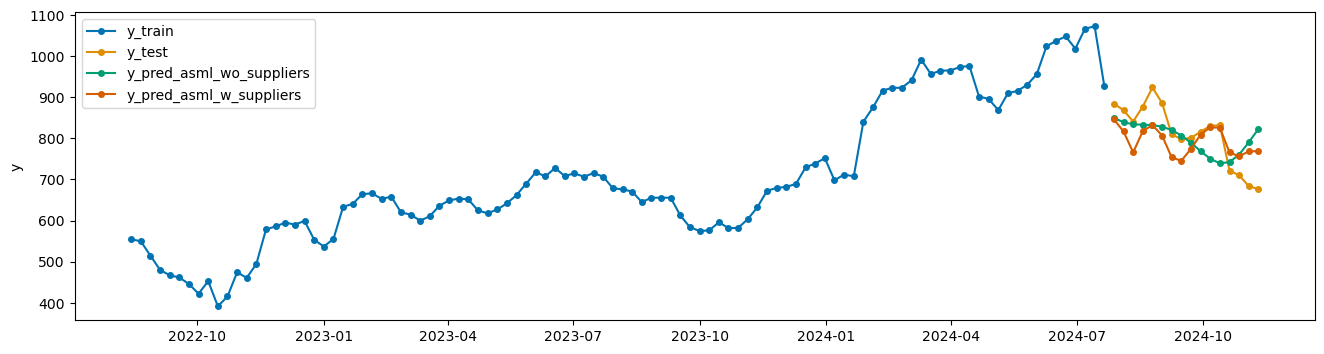

In [16]:
# Plot the series with train, test, and predictions from both models
plot_series(
    train_data['y'][500:],          # Training data starting from index 500 for better visualization
    test_data['y'],                 # Test data for comparison
    forecast_model_asml,            # Predictions from the ASML model
    forecast_model_asml_suppliers,  # Predictions from the ASML suppliers model
    labels=["y_train", "y_test", "y_pred_asml_wo_suppliers", "y_pred_asml_w_suppliers"]  # Labels for each line in the plot
)


#### 2.3.6.2 Comparing metrics

MAPE and RMSE of the model forecast_model_asml (without supplier/exogenous data)

In [17]:
print("MAPE:", best_prophet_variables_asml['mape_prophet_best'])
print()
print("RMSE:", best_prophet_variables_asml['rmse_prophet_best'])

MAPE: 6.707679716202576

RMSE: 65.79222754282031


MAPE and RMSE of the model forecast_model_asml_suppliers (with supplier/exogenous data)

In [18]:
print("MAPE:", best_prophet_variables_asml_suppliers['mape_prophet_best_with_suppliers'])
print()
print("RMSE:", best_prophet_variables_asml_suppliers['rmse_prophet_best_with_suppliers'])

MAPE: 6.403370313798415

RMSE: 58.39888901221398
